# argo box analysis

This notebook will walk through our analysis framework for a single box. I feel like lots of my notes/work are scattered around different notebooks, so I think it will be helpful to organize everything in one place to think through the flow of our analysis and also identify weak points that still need to be examined more closely.

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

As I conceptualize it, below are the elements of the analysis that should be included in this notebook:
- plot contours of temperature, salinity, density, and spice
- select a few interesting spice profiles and show filtering and masking techniques
- plot average MLD and profiles by season
- plot average ratio quantities by depth
- plot spectra for whole profile and masks profiles
- plot EKE/MKE binned by both scale and depth respectively (try with whole profile and masked profiles)

## Select and Plot Box

In [3]:
box_z = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_z.nc')
box_r = xr.open_dataset('202206_boxes/lon:(25,30)_lat:(-60,-55)_ds_rho.nc')

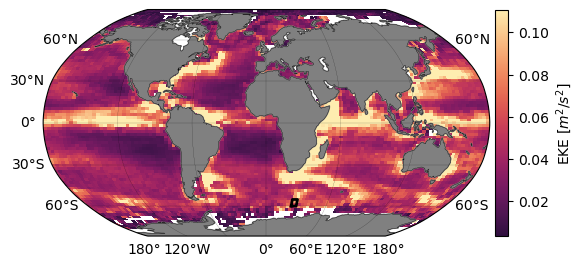

In [4]:
pf.plot_box([[25,30,-60,-55]])

In [5]:
box_z = mf.get_MLD(box_z)
box_z = mf.add_times(box_z)

Text(0.5, 1.0, 'Fractional Months & Years')

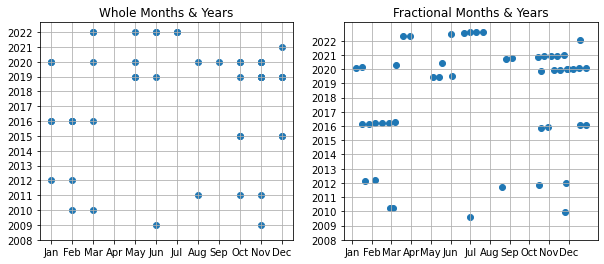

In [6]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(box_z.month,box_z.year)
plt.yticks(range(2008,2023),range(2008,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Whole Months & Years')

plt.subplot(1,2,2)
plt.scatter(box_z.month_frac,box_z.year_frac)
plt.yticks(range(2008,2023),range(2008,2023))
plt.xticks(range(1,13),months)
plt.grid()
plt.title('Fractional Months & Years')

These plots are so pretty, they make me very happy to look at them for different boxes.

On another note, I chose a small box (5 by 5) because I was hoping that seasonal signals might come out stronger? (ie if hopefully a smaller region would have a cohesive seasonal signal instead of picking up a few different things happening at once.) But now when I see how few profiles we have, I wonder if noise from averaging over limited data will be another difficult problem to work through.

## Plot Tracers and Profiles

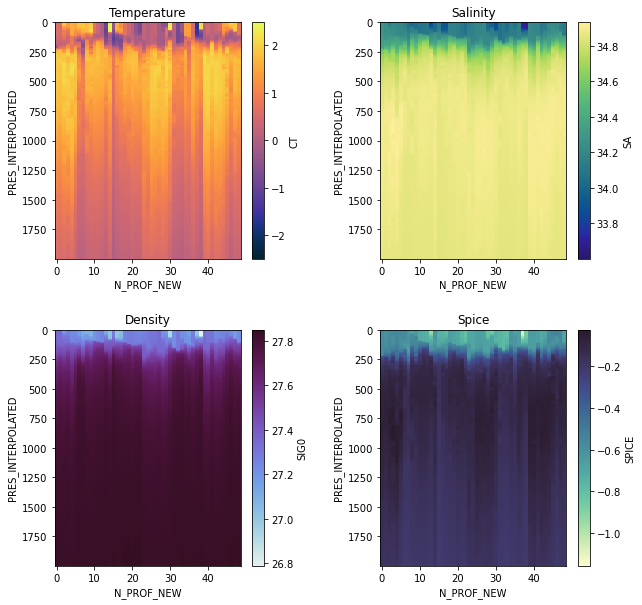

In [7]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
box_z.CT.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.thermal)
plt.gca().invert_yaxis()
plt.title('Temperature')

plt.subplot(2,2,2)
box_z.SA.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.haline)
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(2,2,3)
box_z.SIG0.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.title('Density')

plt.subplot(2,2,4)
box_z.SPICE.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',cmap=cmo.deep)
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplots_adjust(hspace=0.3,wspace=0.4)

any comments to add here? Not really I guess

In [8]:
CT_100 = ff.get_filt_single(box_z,100,'CT')
CT_200 = ff.get_filt_single(box_z,200,'CT')
CT_400 = ff.get_filt_single(box_z,400,'CT')

SA_100 = ff.get_filt_single(box_z,100,'SA')
SA_200 = ff.get_filt_single(box_z,200,'SA')
SA_400 = ff.get_filt_single(box_z,400,'SA')

SIG0_100 = ff.get_filt_single(box_z,100,'SIG0')
SIG0_200 = ff.get_filt_single(box_z,200,'SIG0')
SIG0_400 = ff.get_filt_single(box_z,400,'SIG0')

SPICE_100 = ff.get_filt_single(box_z,100,'SPICE')
SPICE_200 = ff.get_filt_single(box_z,200,'SPICE')
SPICE_400 = ff.get_filt_single(box_z,400,'SPICE')

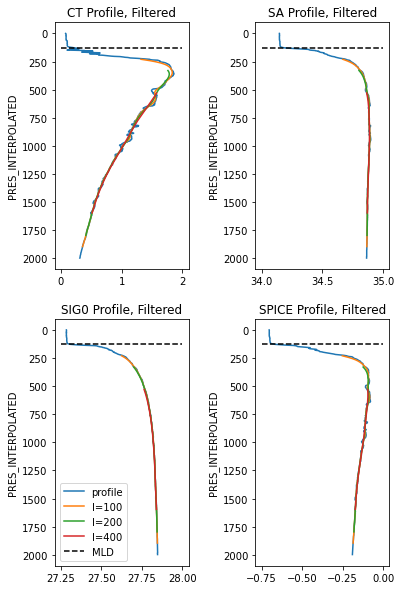

In [9]:
n=20
plt.figure(figsize=(6,10))

plt.subplot(2,2,1)
box_z.CT.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
CT_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),0,2,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('CT Profile, Filtered')

plt.subplot(2,2,2)
box_z.SA.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SA_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),34,35,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('SA Profile, Filtered')

plt.subplot(2,2,3)
box_z.SIG0.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='profile')
SIG0_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=100')
SIG0_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=200')
SIG0_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='l=400')
plt.hlines(box_z.MLD.isel(N_PROF=n),27.25,28,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.legend()
plt.title('SIG0 Profile, Filtered')

plt.subplot(2,2,4)
box_z.SPICE.isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_100.where(CT_100.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_200.where(CT_200.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
SPICE_400.where(CT_400.mask==1).isel(N_PROF=n).plot(y='PRES_INTERPOLATED')
plt.hlines(box_z.MLD.isel(N_PROF=n),-0.75,0,color='k',linestyle='--',label='MLD')
plt.gca().invert_yaxis()
plt.title('SPICE Profile, Filtered')

plt.subplots_adjust(wspace=0.5)

I included these profiles mostly to show how the mask works and how much of the profile it removes at certain scales. I still worry that cutting off that much of the profile makes it difficult to draw significant conclusions? Additionally, I'm not sure how the functions I've already written take masking into account, so keep an eye on that as time goes on.

## Plot MLD

In [10]:
SIG0_01 = box_z.SIG0.where(box_z.month<2).dropna('N_PROF')
SIG0_02 = box_z.SIG0.where(box_z.month<3).where(box_z.month>1).dropna('N_PROF')
SIG0_03 = box_z.SIG0.where(box_z.month<4).where(box_z.month>2).dropna('N_PROF')
SIG0_04 = box_z.SIG0.where(box_z.month<5).where(box_z.month>3).dropna('N_PROF')
SIG0_05 = box_z.SIG0.where(box_z.month<6).where(box_z.month>4).dropna('N_PROF')
SIG0_06 = box_z.SIG0.where(box_z.month<7).where(box_z.month>5).dropna('N_PROF')
SIG0_07 = box_z.SIG0.where(box_z.month<8).where(box_z.month>6).dropna('N_PROF')
SIG0_08 = box_z.SIG0.where(box_z.month<9).where(box_z.month>7).dropna('N_PROF')
SIG0_09 = box_z.SIG0.where(box_z.month<10).where(box_z.month>8).dropna('N_PROF')
SIG0_10 = box_z.SIG0.where(box_z.month<11).where(box_z.month>9).dropna('N_PROF')
SIG0_11 = box_z.SIG0.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF')
SIG0_12 = box_z.SIG0.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF')

SIG0_s = [SIG0_01,SIG0_02,SIG0_03,SIG0_04,SIG0_05,SIG0_06,SIG0_07,SIG0_08,SIG0_09,SIG0_10,SIG0_11,SIG0_12]

In [11]:
SPICE_01 = box_z.SPICE.where(box_z.month<2).dropna('N_PROF')
SPICE_02 = box_z.SPICE.where(box_z.month<3).where(box_z.month>1).dropna('N_PROF')
SPICE_03 = box_z.SPICE.where(box_z.month<4).where(box_z.month>2).dropna('N_PROF')
SPICE_04 = box_z.SPICE.where(box_z.month<5).where(box_z.month>3).dropna('N_PROF')
SPICE_05 = box_z.SPICE.where(box_z.month<6).where(box_z.month>4).dropna('N_PROF')
SPICE_06 = box_z.SPICE.where(box_z.month<7).where(box_z.month>5).dropna('N_PROF')
SPICE_07 = box_z.SPICE.where(box_z.month<8).where(box_z.month>6).dropna('N_PROF')
SPICE_08 = box_z.SPICE.where(box_z.month<9).where(box_z.month>7).dropna('N_PROF')
SPICE_09 = box_z.SPICE.where(box_z.month<10).where(box_z.month>8).dropna('N_PROF')
SPICE_10 = box_z.SPICE.where(box_z.month<11).where(box_z.month>9).dropna('N_PROF')
SPICE_11 = box_z.SPICE.where(box_z.month<12).where(box_z.month>10).dropna('N_PROF')
SPICE_12 = box_z.SPICE.where(box_z.month<13).where(box_z.month>11).dropna('N_PROF')

SPICE_s = [SPICE_01,SPICE_02,SPICE_03,SPICE_04,SPICE_05,SPICE_06,SPICE_07,SPICE_08,SPICE_09,SPICE_10,SPICE_11,SPICE_12]

Text(0.5, 1.0, 'Spice Profiles')

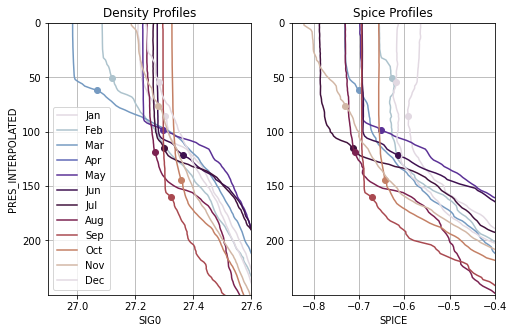

In [12]:
plt.figure(figsize=(8,5))
colors = plt.cm.twilight(np.linspace(0,1,12))

plt.subplot(1,2,1)
for n in range(0,len(SIG0_s)):
    SIG0_mean = SIG0_s[n].mean('N_PROF')
    SIG0_mean.plot(y='PRES_INTERPOLATED',label='{}'.format(months[n]),color=colors[n])
    plt.plot(SIG0_mean.sel(PRES_INTERPOLATED=SIG0_s[n].MLD.mean('N_PROF'),method='nearest'),
             SIG0_s[n].MLD.mean('N_PROF'),marker='o',color=colors[n])

plt.ylim(0,250)
plt.xlim(26.9,27.6)
plt.yticks(range(0,250,50),range(0,250,50))
plt.grid()
plt.gca().invert_yaxis()
plt.legend()
plt.title('Density Profiles')

plt.subplot(1,2,2)
for n in range(0,len(SIG0_s)):
    SPICE_mean = SPICE_s[n].mean('N_PROF')
    SPICE_mean.plot(y='PRES_INTERPOLATED',label='{}'.format(months[n]),color=colors[n])
    plt.plot(SPICE_mean.sel(PRES_INTERPOLATED=SPICE_s[n].MLD.mean('N_PROF'),method='nearest'),
             SPICE_s[n].MLD.mean('N_PROF'),marker='o',color=colors[n])

plt.ylabel('')
plt.ylim(0,250)
plt.xlim(-0.85,-.4)
plt.yticks(range(0,250,50),range(0,250,50))
plt.grid()
plt.gca().invert_yaxis()
plt.title('Spice Profiles')

## Plot Spectra and Ratios

In [13]:
SIG0_spec  = xrft.power_spectrum(box_z.SIG0.mean('N_PROF'), dim='PRES_INTERPOLATED',window='hamming')
SPICE_spec = xrft.power_spectrum(box_z.SPICE.mean('N_PROF'),dim='PRES_INTERPOLATED',window='hamming')
SIG0_m  = SIG0_spec.freq_PRES_INTERPOLATED
SPICE_m = SPICE_spec.freq_PRES_INTERPOLATED

Text(0.5, 1.0, 'Spice Spectra')

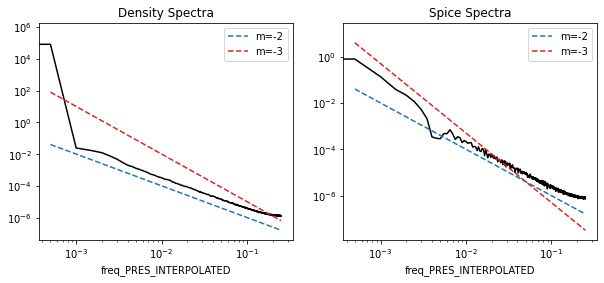

In [14]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
SIG0_spec.plot(color='k')
plt.plot(SIG0_m, 1e-8*SIG0_m**(-2),'--',color='tab:blue',label='m=-2')
plt.plot(SIG0_m, 1e-8*SIG0_m**(-3),'--',color='tab:red', label='m=-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Density Spectra')


plt.subplot(1,2,2)
SPICE_spec.plot(color='k')
plt.plot(SPICE_m, 1e-8*SPICE_m**(-2),'--',color='tab:blue',label='m=-2')
plt.plot(SPICE_m, 5e-10*SPICE_m**(-3),'--',color='tab:red', label='m=-3')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spice Spectra')

This is kind of interesting because it looks like there may be a very subtle break in slope in the spice spectra. At the largest scales it seems to follow a slope of m=-3, but below 100m it's much closer to m=-2. This same pattern is not seen in density.

In [15]:
l1 = 100
l2 = 200
l3 = 400

mke1_d = ef.get_MV(box_z,l1,variable='SIG0',bound=True)
mke2_d = ef.get_MV(box_z,l2,variable='SIG0',bound=True)
mke3_d = ef.get_MV(box_z,l3,variable='SIG0',bound=True)

mke1_s = ef.get_MV(box_z,l1,variable='SPICE',bound=True)
mke2_s = ef.get_MV(box_z,l2,variable='SPICE',bound=True)
mke3_s = ef.get_MV(box_z,l3,variable='SPICE',bound=True)

eke1_d = ef.get_EV(box_z,l1,variable='SIG0',bound=True)
eke2_d = ef.get_EV(box_z,l2,variable='SIG0',bound=True)
eke3_d = ef.get_EV(box_z,l3,variable='SIG0',bound=True)

eke1_s = ef.get_EV(box_z,l1,variable='SPICE',bound=True)
eke2_s = ef.get_EV(box_z,l2,variable='SPICE',bound=True)
eke3_s = ef.get_EV(box_z,l3,variable='SPICE',bound=True)

In [16]:
MKE0_d = eke1_d.where(eke1_d.mask==1)
MKE1_d = mke1_d.where(mke1_d.mask==1) - mke2_d.where(mke2_d.mask==1)
MKE2_d = mke2_d.where(mke2_d.mask==1) - mke3_d.where(mke3_d.mask==1)
MKE3_d = mke3_d.where(mke3_d.mask==1)

MKE0_s = eke1_s.where(eke1_d.mask==1)
MKE1_s = mke1_s.where(mke1_d.mask==1) - mke2_s.where(mke2_d.mask==1)
MKE2_s = mke2_s.where(mke2_d.mask==1) - mke3_s.where(mke3_d.mask==1)
MKE3_s = mke3_s.where(mke3_d.mask==1)

EKE0_d = eke1_d.where(eke1_d.mask==1)
EKE1_d = eke2_d.where(eke2_d.mask==1) - eke1_d.where(eke1_d.mask==1)
EKE2_d = eke3_d.where(eke3_d.mask==1) - eke2_d.where(eke2_d.mask==1)
EKE3_d = mke3_d.where(mke3_d.mask==1)

EKE0_s = eke1_s.where(eke1_d.mask==1)
EKE1_s = eke2_s.where(eke2_d.mask==1) - eke1_s.where(eke1_d.mask==1)
EKE2_s = eke3_s.where(eke3_d.mask==1) - eke2_s.where(eke2_d.mask==1)
EKE3_s = mke3_s.where(mke3_d.mask==1)

In [17]:
R_ex_d = (EKE0_d / MKE3_d).mean('N_PROF')
R_ex_s = (EKE0_s / MKE3_s).mean('N_PROF')

In [18]:
EV_l1_d = ef.get_EV(box_z,l1,variable='SIG0',bound=True)
MV_l1_d = ef.get_MV(box_z,l1,variable='SIG0',bound=True)

EV_l2_d = ef.get_EV(box_z,l2,variable='SIG0',bound=True)
MV_l2_d = ef.get_MV(box_z,l2,variable='SIG0',bound=True)

EV_l3_d = ef.get_EV(box_z,l3,variable='SIG0',bound=True)
MV_l3_d = ef.get_MV(box_z,l3,variable='SIG0',bound=True)


EV_l1_s = ef.get_EV(box_z,l1,variable='SPICE',bound=True)
MV_l1_s = ef.get_MV(box_z,l1,variable='SPICE',bound=True)

EV_l2_s = ef.get_EV(box_z,l2,variable='SPICE',bound=True)
MV_l2_s = ef.get_MV(box_z,l2,variable='SPICE',bound=True)

EV_l3_s = ef.get_EV(box_z,l3,variable='SPICE',bound=True)
MV_l3_s = ef.get_MV(box_z,l3,variable='SPICE',bound=True)

In [19]:
R_l1_d = (EV_l1_d.where(EV_l1_d.mask==1) / MV_l1_d.where(EV_l1_d.mask==1)).mean('N_PROF')
R_l2_d = (EV_l2_d.where(EV_l2_d.mask==1) / MV_l2_d.where(EV_l2_d.mask==1)).mean('N_PROF')
R_l3_d = (EV_l3_d.where(EV_l3_d.mask==1) / MV_l3_d.where(EV_l3_d.mask==1)).mean('N_PROF')

R_l1_s = (EV_l1_s.where(EV_l1_d.mask==1) / MV_l1_s.where(EV_l1_d.mask==1)).mean('N_PROF')
R_l2_s = (EV_l2_s.where(EV_l2_d.mask==1) / MV_l2_s.where(EV_l2_d.mask==1)).mean('N_PROF')
R_l3_s = (EV_l3_s.where(EV_l3_d.mask==1) / MV_l3_s.where(EV_l3_d.mask==1)).mean('N_PROF')

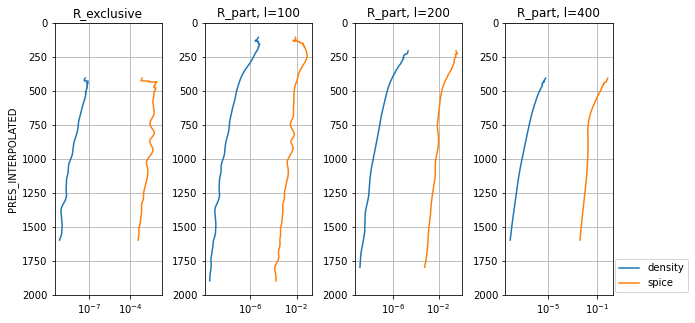

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,4,1)
R_ex_d.plot(y='PRES_INTERPOLATED',label='density')
R_ex_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.title('R_exclusive')

plt.subplot(1,4,2)
R_l1_d.plot(y='PRES_INTERPOLATED',label='density')
R_l1_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.title('R_part, l={}'.format(l1))

plt.subplot(1,4,3)
R_l2_d.plot(y='PRES_INTERPOLATED',label='density')
R_l2_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.title('R_part, l={}'.format(l2))

plt.subplot(1,4,4)
R_l3_d.plot(y='PRES_INTERPOLATED',label='density')
R_l3_s.plot(y='PRES_INTERPOLATED',label='spice')
plt.yticks(range(0,2001,250),range(0,2001,250))
plt.gca().invert_yaxis()
plt.grid()
plt.xscale('log')
plt.ylabel('')
plt.legend(bbox_to_anchor=(1.75,0.15))
plt.title('R_part, l={}'.format(l3))

plt.subplots_adjust(wspace=0.4)

A few things to note here:
- As expected, the density ratio is lower for all ratios because they are small-scale variance over large-scale variance, and we would expect density to be strictly striated and spice to have more variation.
- It's interesting to compare the R_part values for different filter scales. While the general shapes are preserved, features become more drawn out and their depths are distorted. I'm especially looking at the peaks in density ~100m and in spice ~250m when l=100 that appear to occur at ~250m and ~400m when l=400.
- Additionally, this is the point where I wonder if I need to incorporate masking as l changes for R_part so the boundary regions aren't visible. Try this out and see how it goes.

## Plot EKE/MKE by Scale and Depth

In [21]:
MKE0_dm = MKE0_d.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE1_dm = MKE1_d.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE2_dm = MKE2_d.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE3_dm = MKE3_d.sortby('month_frac').sum('PRES_INTERPOLATED')

MKE0_sm = MKE0_s.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE1_sm = MKE1_s.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE2_sm = MKE2_s.sortby('month_frac').sum('PRES_INTERPOLATED')
MKE3_sm = MKE3_s.sortby('month_frac').sum('PRES_INTERPOLATED')

EKE0_dm = EKE0_d.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE1_dm = EKE1_d.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE2_dm = EKE2_d.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE3_dm = EKE3_d.sortby('month_frac').sum('PRES_INTERPOLATED')

EKE0_sm = EKE0_s.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE1_sm = EKE1_s.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE2_sm = EKE2_s.sortby('month_frac').sum('PRES_INTERPOLATED')
EKE3_sm = EKE3_s.sortby('month_frac').sum('PRES_INTERPOLATED')

In [22]:
MKE0_dy = MKE0_d.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE1_dy = MKE1_d.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE2_dy = MKE2_d.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE3_dy = MKE3_d.sortby('year_frac').sum('PRES_INTERPOLATED')

MKE0_sy = MKE0_s.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE1_sy = MKE1_s.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE2_sy = MKE2_s.sortby('year_frac').sum('PRES_INTERPOLATED')
MKE3_sy = MKE3_s.sortby('year_frac').sum('PRES_INTERPOLATED')

EKE0_dy = EKE0_d.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE1_dy = EKE1_d.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE2_dy = EKE2_d.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE3_dy = EKE3_d.sortby('year_frac').sum('PRES_INTERPOLATED')

EKE0_sy = EKE0_s.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE1_sy = EKE1_s.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE2_sy = EKE2_s.sortby('year_frac').sum('PRES_INTERPOLATED')
EKE3_sy = EKE3_s.sortby('year_frac').sum('PRES_INTERPOLATED')

In [23]:
x_m = MKE0_dm.month_frac
x_y  = MKE0_dy.year_frac

Text(0.5, 1.0, 'MKE - EKE, Annual Density Variance')

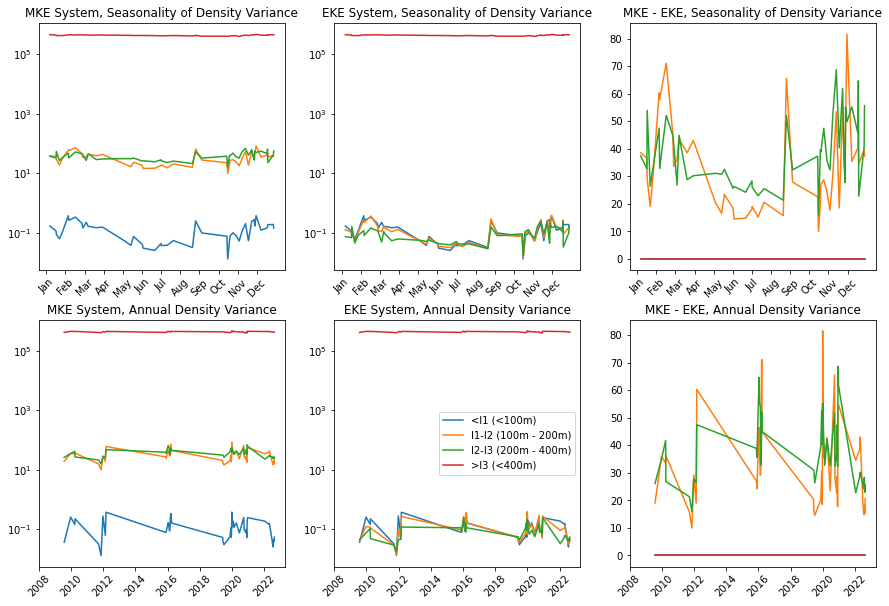

In [32]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(x_m, MKE0_dm, label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, MKE1_dm, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, MKE2_dm, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, MKE3_dm, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.legend()
plt.title('MKE System, Seasonality of Density Variance')

plt.subplot(2,3,2)
plt.plot(x_m, EKE0_dm, label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, EKE1_dm, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, EKE2_dm, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, EKE3_dm, label='>l3 (>{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.legend()
plt.title('EKE System, Seasonality of Density Variance')

plt.subplot(2,3,3)
plt.plot(x_m, (MKE0_dm-EKE0_dm), label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, (MKE1_dm-EKE1_dm), label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, (MKE2_dm-EKE2_dm), label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, (MKE3_dm-EKE3_dm), label='>l3 (>{}m)'.format(l1))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.title('MKE - EKE, Seasonality of Density Variance')

plt.subplot(2,3,4)
plt.plot(x_y, MKE0_dy, label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, MKE1_dy, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, MKE2_dy, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, MKE3_dy, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.yscale('log')
#plt.legend()
plt.title('MKE System, Annual Density Variance')

plt.subplot(2,3,5)
plt.plot(x_y, EKE0_dy, label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, EKE1_dy, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, EKE2_dy, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, EKE3_dy, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.yscale('log')
plt.legend()
plt.title('EKE System, Annual Density Variance')

plt.subplot(2,3,6)
plt.plot(x_y, (MKE0_dy-EKE0_dy), label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, (MKE1_dy-EKE1_dy), label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, (MKE2_dy-EKE2_dy), label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, (MKE3_dy-EKE3_dy), label='>l3 (>{}m)'.format(l1))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.title('MKE - EKE, Annual Density Variance')

Text(0.5, 1.0, 'MKE - EKE, Annual Spice Variance')

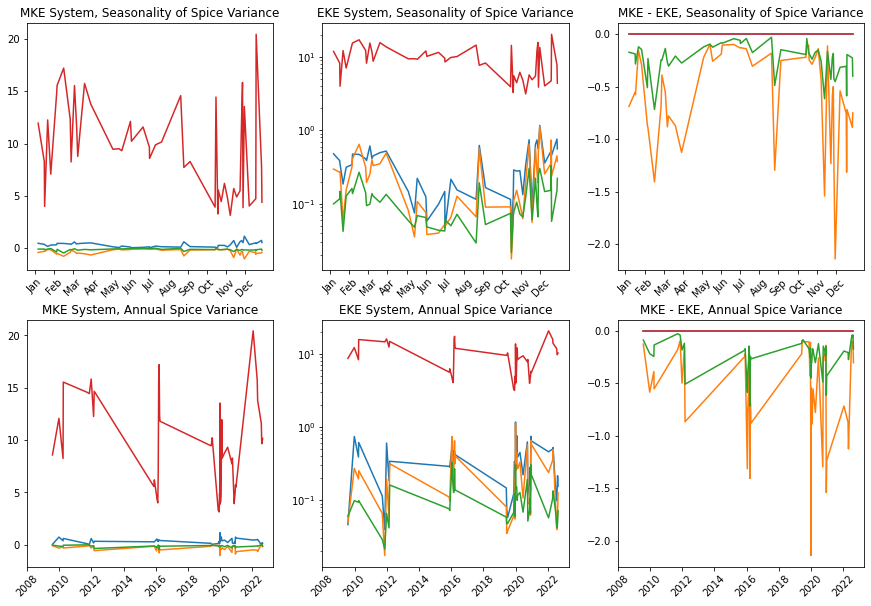

In [35]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(x_m, MKE0_sm, label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, MKE1_sm, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, MKE2_sm, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, MKE3_sm, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
#plt.yscale('log')
#plt.legend()
plt.title('MKE System, Seasonality of Spice Variance')

plt.subplot(2,3,2)
plt.plot(x_m, EKE0_sm, label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, EKE1_sm, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, EKE2_sm, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, EKE3_sm, label='>l3 (>{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.legend()
plt.title('EKE System, Seasonality of Spice Variance')

plt.subplot(2,3,3)
plt.plot(x_m, (MKE0_sm-EKE0_sm), label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, (MKE1_sm-EKE1_sm), label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, (MKE2_sm-EKE2_sm), label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, (MKE3_sm-EKE3_sm), label='>l3 (>{}m)'.format(l1))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.title('MKE - EKE, Seasonality of Spice Variance')

plt.subplot(2,3,4)
plt.plot(x_y, MKE0_sy, label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, MKE1_sy, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, MKE2_sy, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, MKE3_sy, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
#plt.yscale('log')
#plt.legend()
plt.title('MKE System, Annual Spice Variance')

plt.subplot(2,3,5)
plt.plot(x_y, EKE0_sy, label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, EKE1_sy, label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, EKE2_sy, label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, EKE3_sy, label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.yscale('log')
#plt.legend()
plt.title('EKE System, Annual Spice Variance')

plt.subplot(2,3,6)
plt.plot(x_y, (MKE0_sy-EKE0_sy), label='<l1 (<{}m)'.format(l1))
plt.plot(x_y, (MKE1_sy-EKE1_sy), label='l1-l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_y, (MKE2_sy-EKE2_sy), label='l2-l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_y, (MKE3_sy-EKE3_sy), label='>l3 (>{}m)'.format(l1))
plt.xticks(ticks=range(2008,2024,2),labels=range(2008,2024,2),rotation=45)
plt.title('MKE - EKE, Annual Spice Variance')

## REWRITE, masking has changed the thought process on this

A few things to note for density:
- First, seasonality does look much smoother in these plots than in the steinberg notebook when I used a much larger box and there were significant oscillations. So that's good news.
- As expected, density's large-scale gradient completely dominates the plot at all seasons. For both methods, it seems like small-scale variance peaks in ~December and ~March, with a roughly lower period between.
- The MKE system has higher values than EKE and because of this, the sales seem spaced further apart. The second to largest bin varies significantly between the two methods.

A few things to note for spice:
- The large-scale signal also dominates here, but by 1-2 orders of magnitude instead of 4-6.
- It seems harder to pick out a seasonal signal, particularly because the MKE and EKE methods produce opposite signals in some regions. In MKE in December, the middle bins have minima, but in EKE these points are maxima (this disparity can be seen in the MKE-EKE plot). 

All this to say, it's becoming increasingly necessary to figure out what's going on here with the diferences between MKE and EKE

In [26]:
d1 =  150
d2 =  500
d3 = 1000

In [27]:
EKE0_dm0 = EKE0_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE1_dm0 = EKE1_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE2_dm0 = EKE2_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE3_dm0 = EKE3_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')

EKE0_dm1 = EKE0_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE1_dm1 = EKE1_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE2_dm1 = EKE2_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE3_dm1 = EKE3_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')

EKE0_dm2 = EKE0_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE1_dm2 = EKE1_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE2_dm2 = EKE2_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE3_dm2 = EKE3_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')

EKE0_dm3 = EKE0_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE1_dm3 = EKE1_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE2_dm3 = EKE2_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE3_dm3 = EKE3_d.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')

In [28]:
EKE0_sm0 = EKE0_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE1_sm0 = EKE1_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE2_sm0 = EKE2_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')
EKE3_sm0 = EKE3_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d1).sum('PRES_INTERPOLATED')

EKE0_sm1 = EKE0_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE1_sm1 = EKE1_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE2_sm1 = EKE2_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')
EKE3_sm1 = EKE3_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d2).where(box_z.PRES_INTERPOLATED>d1).sum('PRES_INTERPOLATED')

EKE0_sm2 = EKE0_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE1_sm2 = EKE1_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE2_sm2 = EKE2_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')
EKE3_sm2 = EKE3_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED<d3).where(box_z.PRES_INTERPOLATED>d2).sum('PRES_INTERPOLATED')

EKE0_sm3 = EKE0_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE1_sm3 = EKE1_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE2_sm3 = EKE2_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')
EKE3_sm3 = EKE3_s.sortby('month_frac').where(box_z.PRES_INTERPOLATED>d3).sum('PRES_INTERPOLATED')

Text(0.5, 1.0, '(6) >1000m depth')

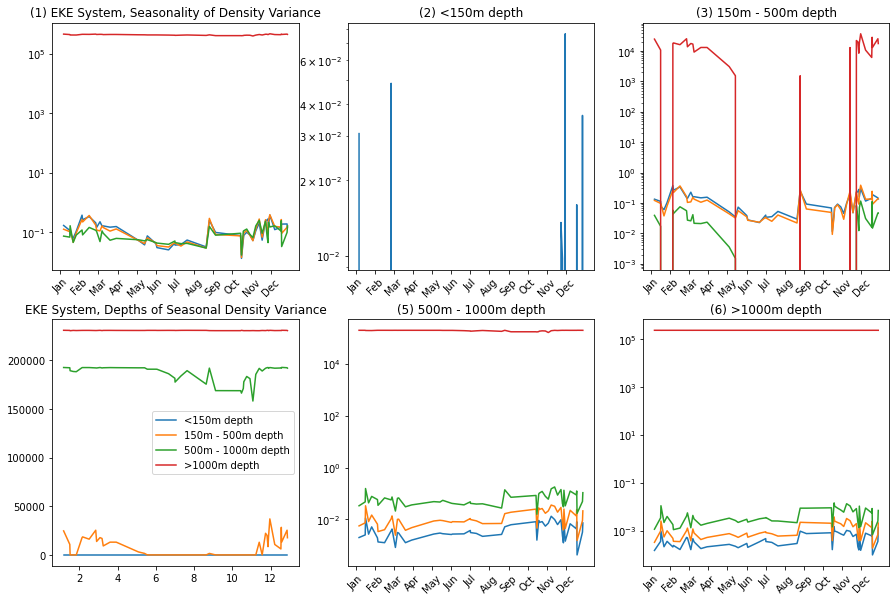

In [37]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(x_m, EKE0_dm,label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, EKE1_dm,label='l1 - l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, EKE2_dm,label='l2 - l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, EKE3_dm,label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.ylim((10**-4,10**6))
plt.title('(1) EKE System, Seasonality of Density Variance')

plt.subplot(2,3,2)
plt.plot(x_m, EKE0_dm0)
plt.plot(x_m, EKE1_dm0)
plt.plot(x_m, EKE2_dm0)
plt.plot(x_m, EKE3_dm0)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.ylim((10**-4,10**6))
plt.title('(2) <{}m depth'.format(d1))

plt.subplot(2,3,3)
plt.plot(x_m, EKE0_dm1)
plt.plot(x_m, EKE1_dm1)
plt.plot(x_m, EKE2_dm1)
plt.plot(x_m, EKE3_dm1)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.ylim((10**-4,10**6))
plt.title('(3) {}m - {}m depth'.format(d1,d2))

plt.subplot(2,3,4)
plt.plot(x_m, (EKE0_dm0+EKE1_dm0+EKE2_dm0+EKE3_dm0),label='<{}m depth'.format(d1))
plt.plot(x_m, (EKE0_dm1+EKE1_dm1+EKE2_dm1+EKE3_dm1),label='{}m - {}m depth'.format(d1,d2))
plt.plot(x_m, (EKE0_dm2+EKE1_dm2+EKE2_dm2+EKE3_dm2),label='{}m - {}m depth'.format(d2,d3))
plt.plot(x_m, (EKE0_dm3+EKE1_dm3+EKE2_dm3+EKE3_dm3),label='>{}m depth'.format(d3))
plt.legend()
plt.title('EKE System, Depths of Seasonal Density Variance')

plt.subplot(2,3,5)
plt.plot(x_m, EKE0_dm2)
plt.plot(x_m, EKE1_dm2)
plt.plot(x_m, EKE2_dm2)
plt.plot(x_m, EKE3_dm2)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.ylim((10**-4,10**6))
plt.title('(5) {}m - {}m depth'.format(d2,d3))

plt.subplot(2,3,6)
plt.plot(x_m, EKE0_dm3)
plt.plot(x_m, EKE1_dm3)
plt.plot(x_m, EKE2_dm3)
plt.plot(x_m, EKE3_dm3)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
#plt.ylim((10**-4,10**6))
plt.title('(6) >{}m depth'.format(d3))

Take a closer look at this, I'm very skeptical of panel (4)? Maybe this is just a feature of density and not spice?

Text(0.5, 1.0, '(6) >1000m depth')

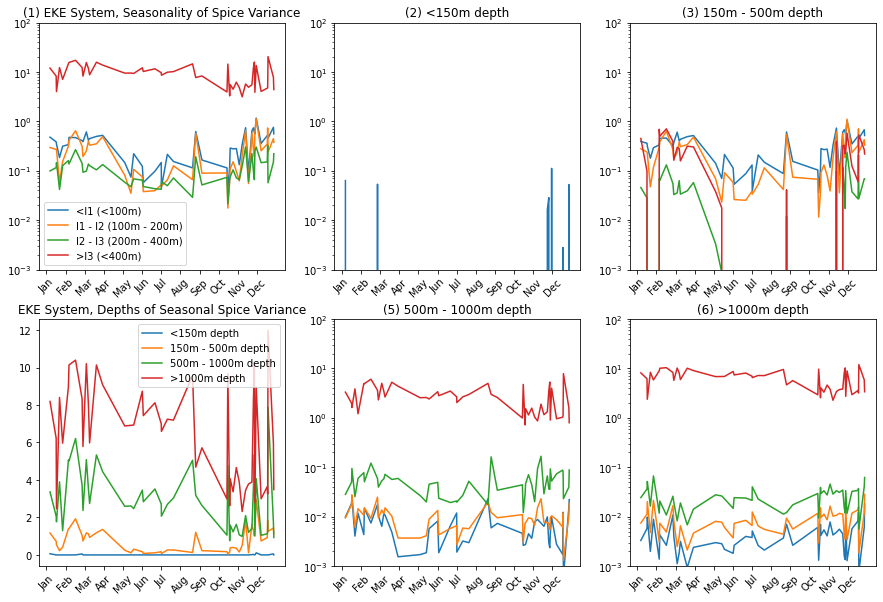

In [30]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(x_m, EKE0_sm,label='<l1 (<{}m)'.format(l1))
plt.plot(x_m, EKE1_sm,label='l1 - l2 ({}m - {}m)'.format(l1,l2))
plt.plot(x_m, EKE2_sm,label='l2 - l3 ({}m - {}m)'.format(l2,l3))
plt.plot(x_m, EKE3_sm,label='>l3 (<{}m)'.format(l3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
plt.ylim((10**-3,10**2))
plt.legend()
plt.title('(1) EKE System, Seasonality of Spice Variance')
        
plt.subplot(2,3,2)
plt.plot(x_m, EKE0_sm0)
plt.plot(x_m, EKE1_sm0)
plt.plot(x_m, EKE2_sm0)
plt.plot(x_m, EKE3_sm0)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
plt.ylim((10**-3,10**2))
plt.title('(2) <{}m depth'.format(d1))

plt.subplot(2,3,3)
plt.plot(x_m, EKE0_sm1)
plt.plot(x_m, EKE1_sm1)
plt.plot(x_m, EKE2_sm1)
plt.plot(x_m, EKE3_sm1)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
plt.ylim((10**-3,10**2))
plt.title('(3) {}m - {}m depth'.format(d1,d2))

plt.subplot(2,3,4)
plt.plot(x_m, (EKE0_sm0+EKE1_sm0+EKE2_sm0+EKE3_sm0),label='<{}m depth'.format(d1))
plt.plot(x_m, (EKE0_sm1+EKE1_sm1+EKE2_sm1+EKE3_sm1),label='{}m - {}m depth'.format(d1,d2))
plt.plot(x_m, (EKE0_sm2+EKE1_sm2+EKE2_sm2+EKE3_sm2),label='{}m - {}m depth'.format(d2,d3))
plt.plot(x_m, (EKE0_sm3+EKE1_sm3+EKE2_sm3+EKE3_sm3),label='>{}m depth'.format(d3))
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.legend()
plt.title('EKE System, Depths of Seasonal Spice Variance')

plt.subplot(2,3,5)
plt.plot(x_m, EKE0_sm2)
plt.plot(x_m, EKE1_sm2)
plt.plot(x_m, EKE2_sm2)
plt.plot(x_m, EKE3_sm2)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
plt.ylim((10**-3,10**2))
plt.title('(5) {}m - {}m depth'.format(d2,d3))

plt.subplot(2,3,6)
plt.plot(x_m, EKE0_sm3)
plt.plot(x_m, EKE1_sm3)
plt.plot(x_m, EKE2_sm3)
plt.plot(x_m, EKE3_sm3)
plt.xticks(ticks=range(1,13),labels=months,rotation=45)
plt.yscale('log')
plt.ylim((10**-3,10**2))
plt.title('(6) >{}m depth'.format(d3))

In [49]:
##This could help make plotting the same thing a lot easier
##That's kind of cool

for n in range(0,3):
    #label=('EKE' + join(n))
    label = ''.join(('EKE',str(n),'_dm'))
    print(label)

EKE0_dm
EKE1_dm
EKE2_dm
